<a href="https://colab.research.google.com/github/alexlin51/Mnist_Gans/blob/main/MNIST_GANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])


trainingSet = datasets.MNIST('', download=True,
                            train=True, transform=transform)

trainingLoader = torch.utils.data.DataLoader(trainingSet, batch_size=BATCH_SIZE,
                                            shuffle=True)

In [4]:
class Generator(nn.Module):
  def __init__(self, g_input_dim, g_output_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(g_input_dim, 256)
    self.bn1 = nn.BatchNorm1d(256, momentum=0.8) 
    self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
    self.bn2 = nn.BatchNorm1d(self.fc1.out_features*2, momentum=0.8)
    self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
    self.bn3 = nn.BatchNorm1d(self.fc2.out_features*2, momentum=0.8)
    self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
  
  def forward(self, x): 
    x = self.bn1(F.leaky_relu(self.fc1(x), 0.2))
    x = self.bn2(F.leaky_relu(self.fc2(x), 0.2))
    x = self.bn3(F.leaky_relu(self.fc3(x), 0.2))
    return torch.tanh(self.fc4(x))


In [5]:
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 512)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, 1)
    
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        return torch.sigmoid(self.fc3(x))

In [6]:
d_dim = 100
mnist_dim = trainingSet.data.size(1) * trainingSet.data.size(2)

G = Generator(g_input_dim = d_dim, g_output_dim = mnist_dim).to(device)
D = Discriminator(mnist_dim).to(device)

In [7]:
print(G)
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=1024, bias=True)
  (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=1024, out_features=784, bias=True)
)
Discriminator(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


In [8]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = optim.Adam(G.parameters(), lr = lr)
D_optimizer = optim.Adam(D.parameters(), lr = lr)

In [9]:
def D_train(x):
  D.zero_grad()

  # Creating inputs of real data
  realX, realY = x.view(-1, mnist_dim).to(device), torch.ones(x.size(0), 1).to(device)
  D_real_output = D(realX)
  D_real_loss = criterion(D_real_output, realY)
  
  # Creating inputs of generated data
  z = torch.randn(x.size(0),d_dim).to(device)
  fakeX, fakeY = G(z), torch.zeros(x.size(0), 1).to(device)
  D_fake_output = D(fakeX)
  D_fake_loss = criterion(D_fake_output, fakeY)
  
  # Take the average
  D_loss = (D_fake_loss + D_real_loss)/2
  D_loss.backward()
  D_optimizer.step()

  return D_loss.item()

In [10]:
def G_train():
  G.zero_grad()

  # Is this consider a random distribution?
  z = torch.randn(BATCH_SIZE,d_dim).to(device)
  # We want the Discriminator to think this is all real data
  y = torch.ones(BATCH_SIZE,1).to(device)

  G_output = G(z)
  D_output = D(G_output)
  G_loss = criterion(D_output, y)

  G_loss.backward()
  G_optimizer.step()
  return G_loss.item()

In [11]:
def view_G():
  with torch.no_grad():
    test_z = torch.randn(BATCH_SIZE,d_dim).to(device)
    generate = G(test_z)

    img = generate.view(generate.size(0), 1, 28, 28)
    plt.imshow(img[0].cpu().numpy().squeeze(), cmap='gray_r');
    return img[0]

Starting Generater



Epoch: 1 | D_loss: 0.09690582007169724 | G_loss: 6.140470027923584



Epoch: 2 | D_loss: 0.022191394120454788 | G_loss: 8.100525856018066



Epoch: 3 | D_loss: 0.0367567203938961 | G_loss: 10.43114185333252



Epoch: 4 | D_loss: 0.05664422735571861 | G_loss: 9.771050453186035



Epoch: 5 | D_loss: 0.12330956012010574 | G_loss: 7.819026947021484



Epoch: 6 | D_loss: 0.10412553697824478 | G_loss: 7.130858898162842



Epoch: 7 | D_loss: 0.10768203437328339 | G_loss: 7.323549270629883



Epoch: 8 | D_loss: 0.13128848373889923 | G_loss: 5.851497650146484



Epoch: 9 | D_loss: 0.24276132881641388 | G_loss: 5.063620567321777



Epoch: 10 | D_loss: 0.2686017155647278 | G_loss: 3.7969374656677246



Epoch: 11 | D_loss: 0.2738572359085083 | G_loss: 3.266388416290283



Epoch: 12 | D_loss: 0.3240034878253937 | G_loss: 2.831322193145752



Epoch: 13 | D_loss: 0.39533838629722595 | G_loss: 2.629730463027954



Epoch: 14 | D_loss: 0.3982062339782715 | G_loss: 2.508941173553467



Epoch: 15 | D_loss: 0.3616376221179962 | G_loss: 2.6012208461761475



Epoch: 16 | D_loss: 0.35255610942840576 | G_loss: 2.605229616165161



Epoch: 17 | D_loss: 0.36434388160705566 | G_loss: 2.4333715438842773



Epoch: 18 | D_loss: 0.3759337365627289 | G_loss: 2.2901411056518555



Epoch: 19 | D_loss: 0.3792722523212433 | G_loss: 2.2712340354919434



Epoch: 20 | D_loss: 0.3682255744934082 | G_loss: 2.2501959800720215



Epoch: 21 | D_loss: 0.37662267684936523 | G_loss: 2.287637948989868



Epoch: 22 | D_loss: 0.38852962851524353 | G_loss: 2.149259567260742



Epoch: 23 | D_loss: 0.42104509472846985 | G_loss: 2.065636396408081



Epoch: 24 | D_loss: 0.384438157081604 | G_loss: 2.193408489227295



Epoch: 25 | D_loss: 0.3833923637866974 | G_loss: 2.112839937210083



Epoch: 26 | D_loss: 0.38191869854927063 | G_loss: 2.114596128463745



Epoch: 27 | D_loss: 0.3834612965583801 | G_loss: 2.0967257022857666



Epoch: 28 | D_loss: 0.378395676612854 | G_loss: 2.0870561599731445



Epoch: 29 | D_loss: 0.36902758479118347 | G_loss: 2.145347833633423



Epoch: 30 | D_loss: 0.36337682604789734 | G_loss: 2.1591742038726807



Epoch: 31 | D_loss: 0.38039258122444153 | G_loss: 2.1059155464172363



Epoch: 32 | D_loss: 0.37200644612312317 | G_loss: 2.0737223625183105



Epoch: 33 | D_loss: 0.3671581447124481 | G_loss: 2.138582468032837



Epoch: 34 | D_loss: 0.3736274242401123 | G_loss: 2.112924575805664



Epoch: 35 | D_loss: 0.3772014081478119 | G_loss: 2.0408101081848145



Epoch: 36 | D_loss: 0.3783157765865326 | G_loss: 2.061530828475952



Epoch: 37 | D_loss: 0.3747650980949402 | G_loss: 2.066110134124756



Epoch: 38 | D_loss: 0.38323652744293213 | G_loss: 2.036162853240967



Epoch: 39 | D_loss: 0.3799944818019867 | G_loss: 2.0604043006896973



Epoch: 40 | D_loss: 0.37741225957870483 | G_loss: 2.0309641361236572



Epoch: 41 | D_loss: 0.3885953426361084 | G_loss: 2.0028793811798096



Epoch: 42 | D_loss: 0.38408082723617554 | G_loss: 2.0098812580108643



Epoch: 43 | D_loss: 0.38553091883659363 | G_loss: 1.9972766637802124



Epoch: 44 | D_loss: 0.3892127573490143 | G_loss: 1.9920282363891602



Epoch: 45 | D_loss: 0.39261361956596375 | G_loss: 1.9598312377929688



Epoch: 46 | D_loss: 0.3926699459552765 | G_loss: 1.9583238363265991



Epoch: 47 | D_loss: 0.402182936668396 | G_loss: 1.9058431386947632



Epoch: 48 | D_loss: 0.4028005599975586 | G_loss: 1.8842086791992188



Epoch: 49 | D_loss: 0.4038619101047516 | G_loss: 1.8824843168258667



Epoch: 50 | D_loss: 0.4021739959716797 | G_loss: 1.8927451372146606



Epoch: 51 | D_loss: 0.40795350074768066 | G_loss: 1.8654568195343018



Epoch: 52 | D_loss: 0.4084147810935974 | G_loss: 1.8584024906158447



Epoch: 53 | D_loss: 0.41604021191596985 | G_loss: 1.8631999492645264



Epoch: 54 | D_loss: 0.4216977059841156 | G_loss: 1.788207769393921



Epoch: 55 | D_loss: 0.4229247570037842 | G_loss: 1.7947447299957275



Epoch: 56 | D_loss: 0.42851459980010986 | G_loss: 1.7818149328231812



Epoch: 57 | D_loss: 0.42957955598831177 | G_loss: 1.7672104835510254



Epoch: 58 | D_loss: 0.43462884426116943 | G_loss: 1.7457319498062134



Epoch: 59 | D_loss: 0.43093881011009216 | G_loss: 1.7232905626296997



Epoch: 60 | D_loss: 0.4360041618347168 | G_loss: 1.7200722694396973



Epoch: 61 | D_loss: 0.4333858788013458 | G_loss: 1.7481067180633545



Epoch: 62 | D_loss: 0.43618014454841614 | G_loss: 1.7044123411178589



Epoch: 63 | D_loss: 0.4405805468559265 | G_loss: 1.7247681617736816



Epoch: 64 | D_loss: 0.44181695580482483 | G_loss: 1.718186855316162



Epoch: 65 | D_loss: 0.4437534809112549 | G_loss: 1.718296766281128



Epoch: 66 | D_loss: 0.4441035985946655 | G_loss: 1.6841598749160767



Epoch: 67 | D_loss: 0.44720736145973206 | G_loss: 1.6751117706298828



Epoch: 68 | D_loss: 0.4505986273288727 | G_loss: 1.677091360092163



Epoch: 69 | D_loss: 0.4496553838253021 | G_loss: 1.6438223123550415



Epoch: 70 | D_loss: 0.4529864490032196 | G_loss: 1.6436805725097656



Epoch: 71 | D_loss: 0.45291346311569214 | G_loss: 1.655195951461792



Epoch: 72 | D_loss: 0.45873168110847473 | G_loss: 1.6258786916732788



Epoch: 73 | D_loss: 0.45755335688591003 | G_loss: 1.6401869058609009



Epoch: 74 | D_loss: 0.45643287897109985 | G_loss: 1.6400620937347412



Epoch: 75 | D_loss: 0.461724191904068 | G_loss: 1.6048331260681152



Epoch: 76 | D_loss: 0.45842161774635315 | G_loss: 1.6064023971557617



Epoch: 77 | D_loss: 0.46044617891311646 | G_loss: 1.6106911897659302



Epoch: 78 | D_loss: 0.46056312322616577 | G_loss: 1.599166750907898



Epoch: 79 | D_loss: 0.46034273505210876 | G_loss: 1.6160523891448975



Epoch: 80 | D_loss: 0.46527284383773804 | G_loss: 1.6081771850585938



Epoch: 81 | D_loss: 0.4645974338054657 | G_loss: 1.5745525360107422



Epoch: 82 | D_loss: 0.46092504262924194 | G_loss: 1.6127465963363647



Epoch: 83 | D_loss: 0.4624725580215454 | G_loss: 1.589690089225769



Epoch: 84 | D_loss: 0.46237120032310486 | G_loss: 1.5948108434677124



Epoch: 85 | D_loss: 0.4635850191116333 | G_loss: 1.5858336687088013



Epoch: 86 | D_loss: 0.4677603542804718 | G_loss: 1.5922057628631592



Epoch: 87 | D_loss: 0.4684600830078125 | G_loss: 1.5933341979980469



Epoch: 88 | D_loss: 0.46875959634780884 | G_loss: 1.572044014930725



Epoch: 89 | D_loss: 0.4713159501552582 | G_loss: 1.5763072967529297



Epoch: 90 | D_loss: 0.4740971028804779 | G_loss: 1.56344735622406



Epoch: 91 | D_loss: 0.4684741199016571 | G_loss: 1.5638192892074585



Epoch: 92 | D_loss: 0.4707348644733429 | G_loss: 1.596858024597168



Epoch: 93 | D_loss: 0.4729536175727844 | G_loss: 1.549457311630249



Epoch: 94 | D_loss: 0.47164759039878845 | G_loss: 1.5424354076385498



Epoch: 95 | D_loss: 0.4718198776245117 | G_loss: 1.5545669794082642



Epoch: 96 | D_loss: 0.4711402356624603 | G_loss: 1.5554521083831787



Epoch: 97 | D_loss: 0.4746242165565491 | G_loss: 1.549676775932312



Epoch: 98 | D_loss: 0.4729928970336914 | G_loss: 1.5708197355270386



Epoch: 99 | D_loss: 0.47225886583328247 | G_loss: 1.5571621656417847



Epoch: 100 | D_loss: 0.4744200110435486 | G_loss: 1.5552579164505005



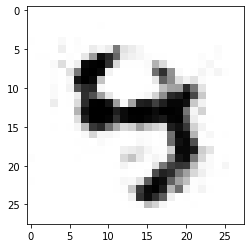

In [12]:
EPOCH = 100;

print('Starting Generater')
view_G()
generated = []
# 938 Batches in a Epoch
for epoch in tqdm(range(1, EPOCH + 1), desc="Epochs Progress"):
  D_losses, G_losses = [], []
  for batch_idx, (x, _) in tqdm(enumerate(trainingLoader), desc="Batch Progress"):
      D_losses.append(D_train(x))
      G_losses.append(G_train())
  
  d_mean = torch.mean(torch.FloatTensor(D_losses))
  g_mean = torch.mean(torch.FloatTensor(G_losses))
  print(f"Epoch: {epoch} | D_loss: {d_mean} | G_loss: {g_mean}")
  generated.append(view_G())

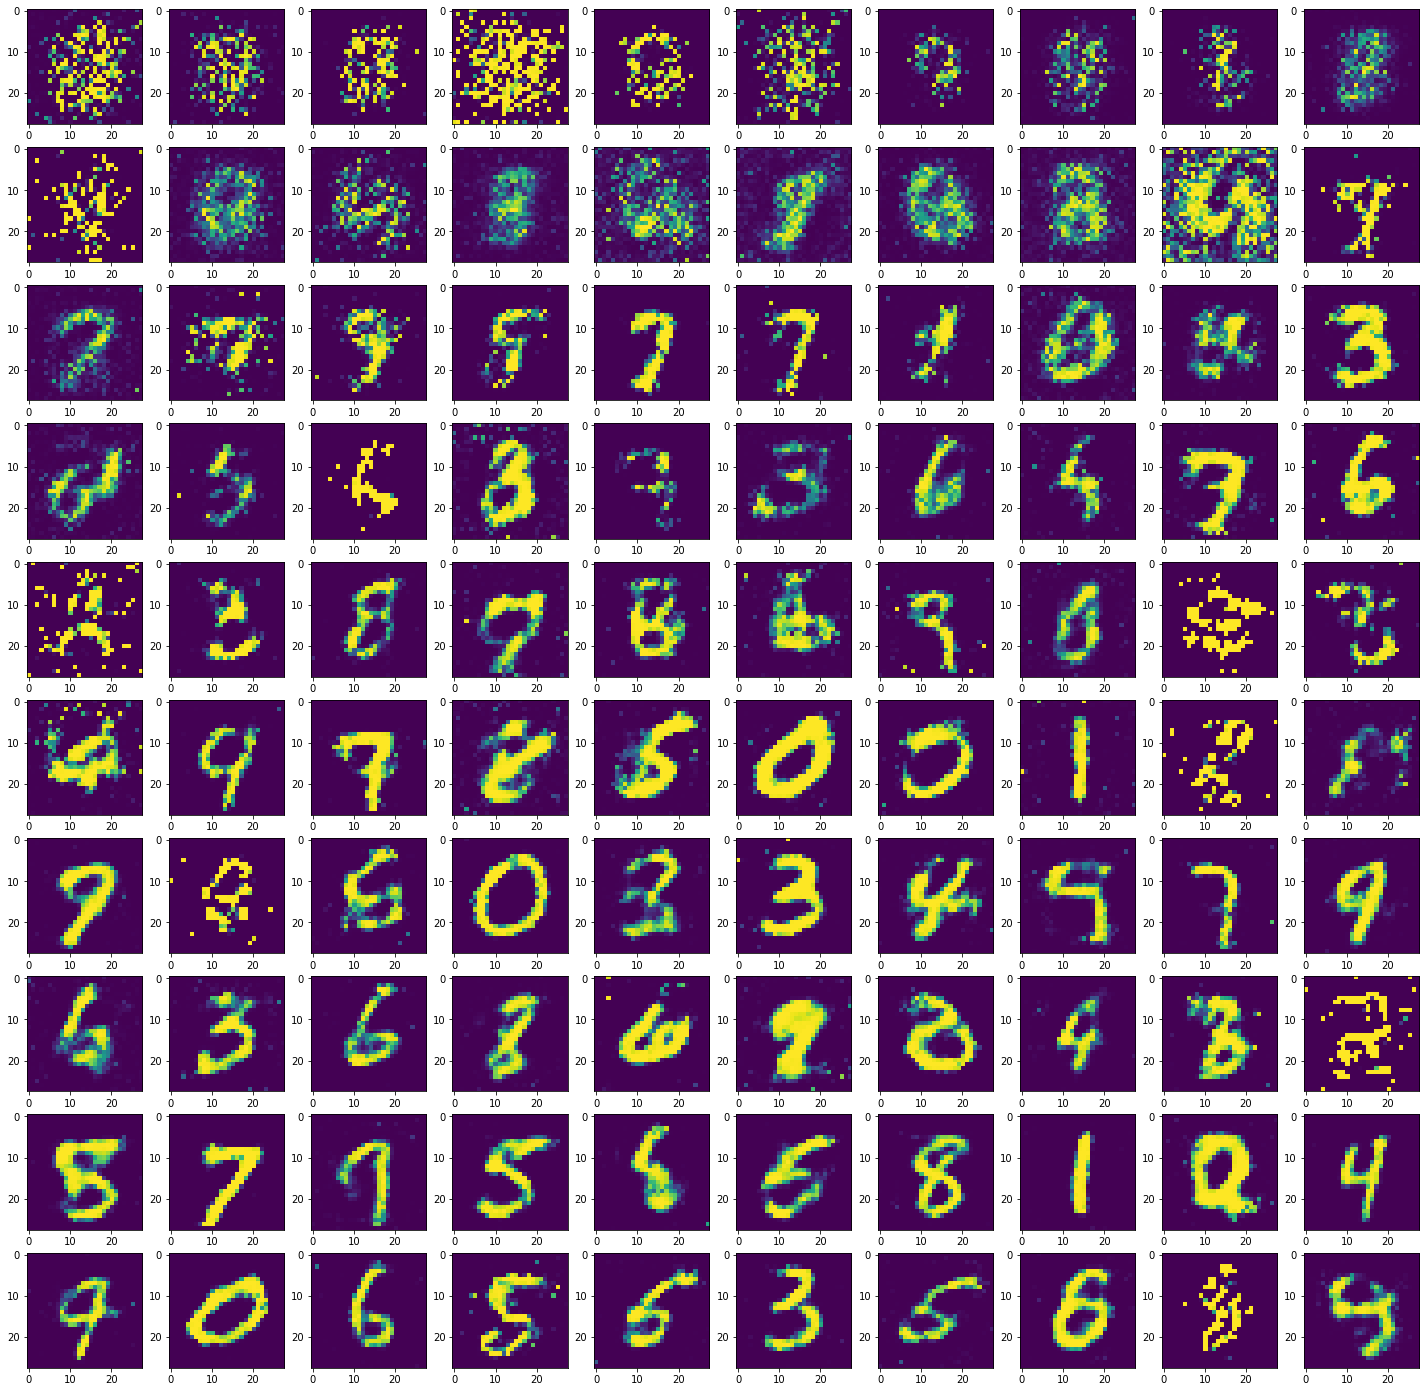

In [14]:
# Display generated images
fig=plt.figure(figsize=(25, 25))
columns = 10
rows = 10
for i in tqdm(range(1, columns*rows +1), desc="Drawing Generated Images"):
    fig.add_subplot(rows, columns, i)
    plt.imshow(generated[i-1][0].cpu())
plt.show()